# 28-02-2024: De flow duidelijk krijgen van accuracy naar AUC naar DCA
Ik heb nu de intiutie wel scherp dat DCA goed is, maar voor de blogpost wil ik een duidelijk opbouw kiezen:

- Laat accuracy zien, leg uit waarom dit niet goed is
- Laat AUC zien, laat zien dat dit een verbetering is tov accuracy
- Laat daarna DCA zien als beste voorbeeld. 

De code hieronder zet alle relevante modellen en data klaar.

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from helper_functions import *

df_cancer_dx = pd.read_csv('https://raw.githubusercontent.com/ddsjoberg/dca-tutorial/main/data/df_cancer_dx.csv')
df_cancer_train, df_cancer_test = train_test_split(df_cancer_dx, test_size=0.3, stratify=df_cancer_dx['cancer'])

complex_model = sm.GLM.from_formula('cancer ~ age + marker + famhistory', data=df_cancer_dx, family=sm.families.Binomial()).fit()

# Accuracy is geen goed idee

We hebben dus 4 modelopties om te kiezen wie wel of niet een biopsy moet krijgen: iedereen, niemand, mensen met een voorgeschiedenis en mensen van wie het complexe model iets vindt. Eerst kijken we naar de accuracy van deze opties. Accuracy is dan (TP+TN)/N_obs, in essesntie hoe vaak je het goede antwoord geeft. 

In [2]:
calc_metrics(input_prob = {'famhistory': df_cancer_test['famhistory'], 
                                    'complex_model': complex_model.predict(df_cancer_test)},
                      true =       df_cancer_test['cancer'],
                      metrics =    'accuracy')

,accuracy_famhistory,accuracy_complex_model,accuracy_everyone,accuracy_noone
0.5,0.782222,0.906667,0.142222,0.857778


Opvallend:

- Niemand een biopsy geven heeft een best wel hoge accuracy, terwijl iedereen een biopsy geven by far de laagste heeft. Belangrijk in deze is dat de accuracy van beide simpelweg het voorkomen van kanker in de data set geeft. `acc_ev = prev` en `acc_noone = 1 - prev`. 
- Niemand biopsy doet het ook nog beter dan een model op basis van famhistory, en het compexe model doet het maar een heel klein beetje beter. 

Wat je hier goed scherp moet hebben is dat accuracy dus gevoelig is voor onbalans in de data (6x meer niet-kanker), en dat in accruacy een TP en een TN precies even 'erg' zijn. In deze medische setting is dat zeker niet het geval: een onnodige biopsie is minder erg dan dat iemand overlijd aan een niet gevonden kanker. 

# 01-03-2024: threshold probabilities en de AUC
Voordeel AUC:
- Heeft geen last can class imbalance. 

Binaire classifiers geven de probability terug dat een observatie 1 is (doe een biopsie). Om dit om te zetten naar een echte binaire (0/1) voorspelling moet je een threshold-probability kiezen waarboven de voorspelling 1 is. Typisch wordt deze threshold als 0.5 gekozen, maar dit kan ook geoptimaliseerd worden. 

Zie bijvoorbeeld de volgende voorspelling op basis van het complexe model of iemand een biopsie moet krijgen of niet:

In [3]:
complex_model.predict(df_cancer_test).head(2)

687    0.062072
682    0.015236
dtype: float64

Deze twee observaties hebben een lage prob, dus het model zegt dat de kans laag is dat deze patient een biopsie nodig heeft. Maar voor deze test set weten we ook of deze mensen kanker hadden of niet. Voor elk van de handelingsopties maken we een nieuwe kolom aan met de waarschijnlijkheden dat een patient een biopsy nodig heeft of niet en visualiseren we deze verdeling voor het complexe model voor de mensen met én zonder kanker:

<Axes: title={'center': 'Density plot'}, ylabel='Density'>

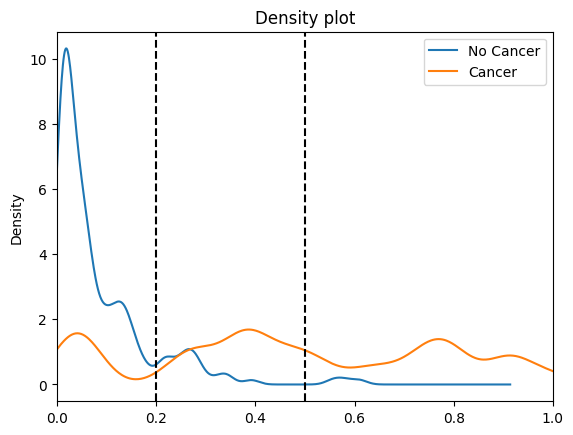

In [4]:
def prob_density_plot(df, y, by, title='Density plot', vline=[0.5, 0.2], labels=['No Cancer', 'Cancer'], bw_method=0.15):
    fig, ax = (df_cancer_test[[by, y]]
        .groupby(by)[y]
        .plot.kde(legend=True, xlim=(0,1), bw_method=bw_method, title=title))
    for v in vline:
        ax.axvline(x=v, color='black', linestyle='--')
    ax.legend(labels)
    return fig

df_cancer_test['complex_prob'] = complex_model.predict(df_cancer_test)
df_cancer_test['famhistory_prob'] = df_cancer_test['famhistory']
df_cancer_test['noone_prob'] = np.zeros(len(df_cancer_test['cancer'])) 
df_cancer_test['everyone_prob'] = np.ones(len(df_cancer_test['cancer'])) 

prob_density_plot(df_cancer_test, y='complex_prob', by='cancer')

Het plot laat de volgende dingen zien:
- Meeste mensen die geen kanker hebben scoren ook laag (<= 0.3) op de waarschijnlijkheid vanuit het complexe model. 
- De verdeling voor kanker patienten is niet zo mooi, zowel hoog als laagscorende patienten hebben kanker. 

# 04-03-2024: De AUC score en roc curve
Om deze waarschijnlijkheidsscore om te zetten naar wél of niet een biopsie doen moeten we een threshold kiezen waarboven we denken dat de patient kanker heeft of niet. De volgende analyse varieert deze threshold waarde en berekent hoe vaak het model correct kanker voorspeld (true positive rate) en hoe vaak het model ten onrechte kanker voorspeld (false positive rate):

<Axes: xlabel='p'>

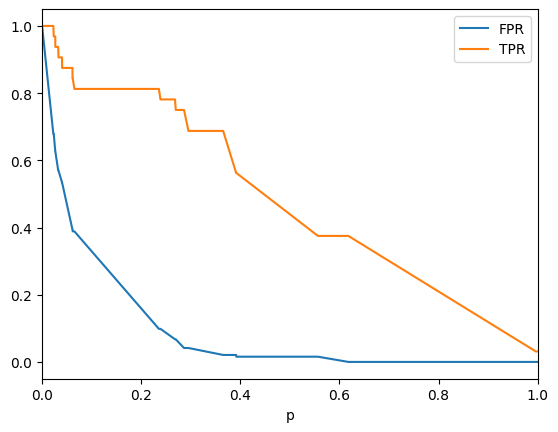

In [5]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr_tpr = pd.DataFrame(roc_curve(df_cancer_test['cancer'], df_cancer_test['complex_prob']), index=['FPR', 'TPR', 'p']).T
fpr_tpr.plot(x='p', xlim = (0,1))

Opvallend:
- Als je de threshold waarde op 0 hebt staan is je TPR 1: je voorspeld dat iedereen kanker gaat krijgen en dus een biopsie nodig heeft. Als tradeoff is the FPR ook super hoog: ook iedereen die géén kanker heeft krijgt een biopsie. 
- Aan de andere kant van het spectrum (p=0) werkt het precies de andere kant op: niemand heeft kanker waardoor je alle kanker patienten geen biopsie geeft (TPR=0), maar er zijn ook geen mensen die ten onrechte een biopsie krijgen. 

Ergens tussen deze twee extremen ligt een ideale tussenweg. Een mooie visualisatie is om de TPR en FPR tegen elkaar uit te zetten:

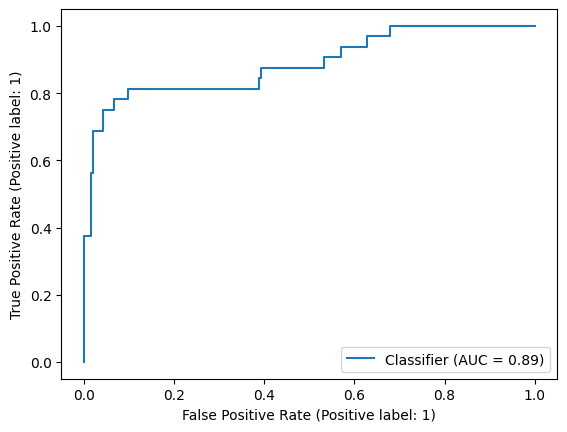

In [6]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = df_cancer_test['complex_prob'])

dit plot is het klassieke ROC curve plot. De oppervlakte onder dit plot (area under curve) geeft de performance van het model over de hele range van mogelijke thresholds. De range voor de AUC is tussen de 0.5 en de 1.0. Het geeft een gevoel voor hoeveel beter het model het doet dan simpelweg een muntje opgooien (0.5). 

Het volgende figuur laat voor alle vier handelingsopties de verdeling van de probabilities en de ROC curve zien:

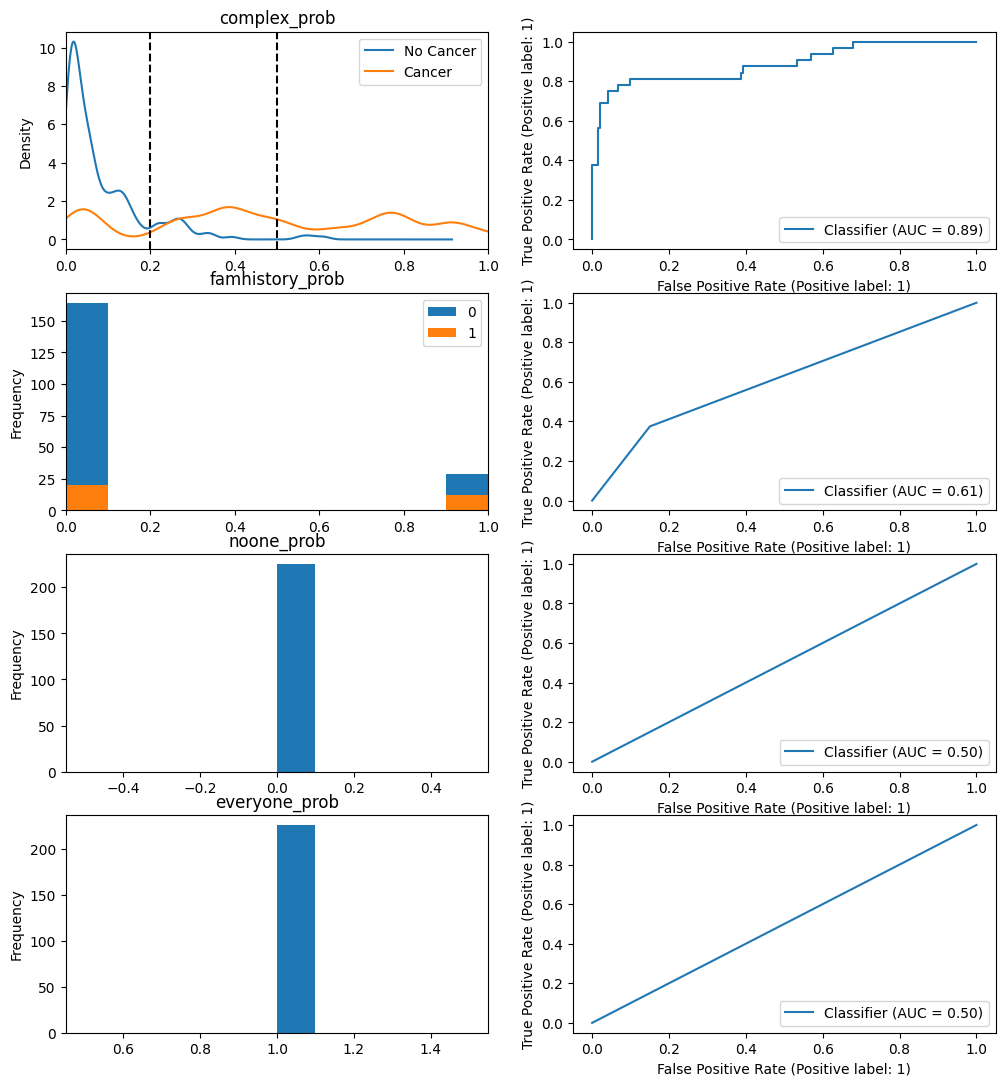

In [7]:
plt.figure(figsize=(12,13))
base_subplot = 420

for i, col in enumerate(['complex_prob', 'famhistory_prob', 'noone_prob', 'everyone_prob']):
    roc_pos_offset = (2*(i + 1))
    plt.subplot(base_subplot + roc_pos_offset - 1)
    if col == 'complex_prob':
        prob_density_plot(df_cancer_test, col, 'cancer', title=col)
    elif col == 'famhistory_prob':
        df_cancer_test.groupby('cancer')[col].plot.hist(legend=True, xlim=(0,1), title=col)
    else:
        df_cancer_test[col].plot(kind='hist', title=col)

    ax = plt.subplot(base_subplot + roc_pos_offset)
    RocCurveDisplay.from_predictions(y_true = df_cancer_test['cancer'], y_pred = df_cancer_test[col], ax=ax)

Opvallend:

- De niet-complexe handelingsopties doen het niet beter dan willekeurig kiezen welke patienten een biopsie nodig hebben. 
- Het famhistory model heeft niet een mooie gladde verdeling van probabilities: als een patient een famhistory heeft is de probablity 1, anders is deze 0. 
- Het fam_hist model heeft wel een significant effect: de fractie gezonde patienten is veel hoger bij famhistory=0 dan bij famhistory is 1. Maar er zijn kanker en niet-kanker patienten bij zowel famhis=1 als 0. Dit leidt er toe dat de AUC, ondanks het effect wat wel bestaat, leidt tot een zeer lage AUC score. 
- Het complexe model heeft verreweg de hoogste performance. Hier zijn een tweetal extra variabelen toegevoegd naast famhistory. Deze verbeteren het model significant. 
- Zowel no one als everyone hebben een simpele verdeling qua probabilities, alles 0 en alles 1 respectively. Beide leiden tot een AUC van 0.5, wat betekend dat je volgens deze metric net zo goed een muntje kan opgooien. Dit in contrast tot de accuracy, welke no one een betere score gaf dan het complexe model. 

De ROC curve en de AUC kunnen dus wel omgaan met ongeblanceerde data, en zijn daarmee een veel betere manier om te bepalen welke handelingsoptie een goed idee is of niet. 

# 05-03-2024: op naar net_benefit

De AUC score kan dus beter omgaan met data die ongebalanceerd is. Dit kun je vooral goed zien aan dat de accuracy van de 'geef niemand een biopsie' optie een hoge accuracy heeft, maar een zeer lage AUC score. Maar tot nu toe hebben alle metrics nog de eigenschap dat elke fout (FP, FN) precies evenveel invloed heeft op de waarde van de metric. Intuitief is dit raar: het missen van een kankerpatient leidt tot een enorm grote kans dat iemand overlijdt, een onnodige biopsie is niet even impactful als dit. 

Decision curve analyse introduceert net_benefit:

In [8]:
def net_benefit(sensitivity, specificity, prevalence, threshold):
    return (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence)) * (threshold / (1 - threshold))

Bedenk dat deze hele rekenklus in fracties denkt. De hele dataset is 1.0, alle onderstaande zaken zijn een fractie van deze 1.0 totale populatie:

- Sensitivity: hoe goed is het model in het detecteren van kanker. Dit wordt ook wel de True Positive Rate genoemd: who of the cancer patients is actually classified as a cancer patient. 
- Specificity: hoe goed is het model in het detecteren van niet-kanker (TNR): welke fracite van de niet-kanker patienten wordt ook daadwerkelijk als niet kaner geclassificeerd
- prevalence: hoe vaak komt kanker voor in de dataset
- threeshold: hoeveel risico zijn we bereid om te nemen. Een treshold van 0.1 betekend dat we bereid zijn om 9 valse biopsies te accepteren voor elke TP. 
- sens * prev: fractie van de populatie die True Positive is. Die dus terecht een biopsie krijgt. 
- (1-spec) * (1-prev): fractie van de populatie die ten onrechte een biopsie krijgt. 
- (threshold / (1-threshold)): hier wordt het risico omgezet naar een odd. Dit getal geeft aan hoeveel erger je een gemiste kanker patient vindt tov een onterechte biopsie. 

# Relatie tussen AUC/net_benefit en sensitivity en specificity
Om goed het verband tusesn de verschillende metrics te illustreren wil ik ze koppelen aan de termen sensitivity en specificity. 

| Name  |  Alt name | intuition | formula |  
|---|---|---|---|
| Accuracy  |   | How accurately can the model predict which patient will get cancer or not  | $$ACC = \frac{TP + TN}{n_{cancer} + n_{non-cancer}}$$ |
| True Positive rate  | sensitivity  | How good is the model at detecting cancer when somebody actually has cancer  | $$TPR = \frac{TP}{n_{cancer}}  $$ |
| False positive rate  |   | How often does the model wrongly predict cancer for non-cancer patients  | $$FPR = \frac{FP}{n_{non-cancer}} $$ |
| True negative rate| specificity | How good is the model at detecting non-cancer when the patient does not have cancer | $$TNR = \frac{TN}{n_{non-cancer}}  $$ | 
| ROC curve value |  | For a given threshold $\theta$, what is the FPR and the TPR of the model given the data. (FPR, TPR) is then a point on the ROC curve.  |$$(x,y)_{\theta} = (FPR_{\theta}, TPR_{\theta})$$  $$FPR_{\theta} = \frac{\sum_{i=0}^{n_{non-cancer}} \left\{ \begin{array}{c l} p_{i} >= \theta  & 1 \\ \mathrm{else} & 0 \end{array} \right. \neq obs_{i}}{n_{non-cancer}} $$ $$ TPR_{\theta} = \frac{\sum_{i=0}^{n_{cancer}} \left\{ \begin{array}{c l} p_{i} >= \theta  & 1 \\ \mathrm{else} & 0 \end{array} \right. = obs_{i}}{n_{cancer}} $$ |
| Area under (roc) curve |   |The area under the roc curve. Provides the overall performance of a model across a range of threshold values. |
| net benefit |  | The net benefit that the model shows at a given threshold $\theta$. The positive side of this net benefit is the fraction of total patients that was correctly diagnosed as having cancer ($TPR \times \frac{n_{cancer}}{n}$), and the negative side as the fraction of total patients that got an unneeded biopsy ($FPR \times \frac{n_{non-cancer}}{n}$). So the positive side are the correctly diagnosed cancer patients, the negative side are the unnecessary biopsies. The last term ($\frac{\theta}{1-\theta}$) determines how much less of a problem the uneccessary biopsies are. For example, a $\theta$ of 0.2 means ($\frac{\theta}{1-\theta}=0.25$), that means that unecessary biopsies are 4 times less important, thus we accept 4 unecessary biopsies for each extra cancer patient we find.  |$$NB_{\theta} = TPR_{\theta} \times \frac{n_{cancer}}{n} - (1-TNR_{\theta}) \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$ $$NB_{\theta} = TPR_{\theta} \times \frac{n_{cancer}}{n} - FPR_{\theta} \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$

Observations:
- AUC is niet gevoelig voor onbalans omdat het kijkt naar de $rate$ van zowel de positieve als negatieve uitkomsten, en niet naar het absolute aantal
- net_benefit neemt ook het aantal wel/niet kanker patienten mee in de rekensom, en maakt de kosten en de baten expliciet. 
- Bij net_benefit zijn de kosten en de baten niet noodzakelijker wijs van gelijk gewicht, je kunt de kosten (onnodige biopsie) minder van belang vinden dan de baten (correct inschatting kanker). 

# 07-03-2024: Verder inzichtelijk maken wat de net_benefit nu precies is

$n_{cancer}$ and $n_{non-cancer}$, dit is simplweg het aantal kanker en niet kanker patienten in de testdataset. Hier zie je direct waarom accuracy zo hoog is voor de niet-kanker voorspelling, de data is niet gebalanceerd. 

<Axes: xlabel='cancer'>

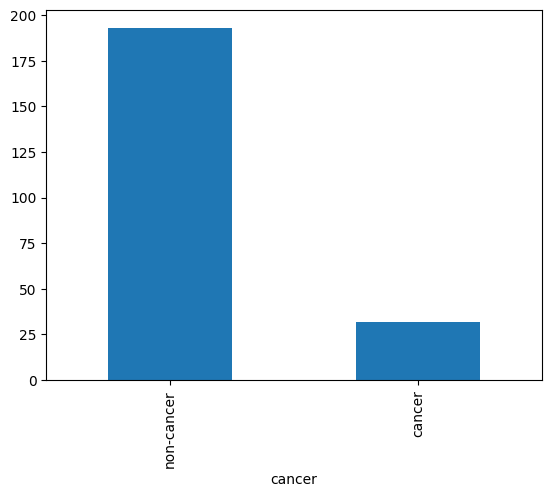

In [41]:
df_ill = df_cancer_test.replace({'cancer': {0: 'non-cancer', 1: 'cancer'}})
df_ill.value_counts('cancer').plot(kind='bar')

$prevalence_{cancer} = \frac{n_{cancer}}{n}$ and $prevalence_{non-cancer} = \frac{n_{non-cancer}}{n}$, hier zetten we de waardes om naar fracties van de totale populatie. Dit wordt ook wel de prevalence genoemd. In dit geval is de prevalence van kanker zo'n 0.14. Hier is ook een mooie link naar accuracy. Een model wat altijd niet-kanker teruggeeft zou een accuracy van 0.86 hebben. 

<Axes: xlabel='cancer'>

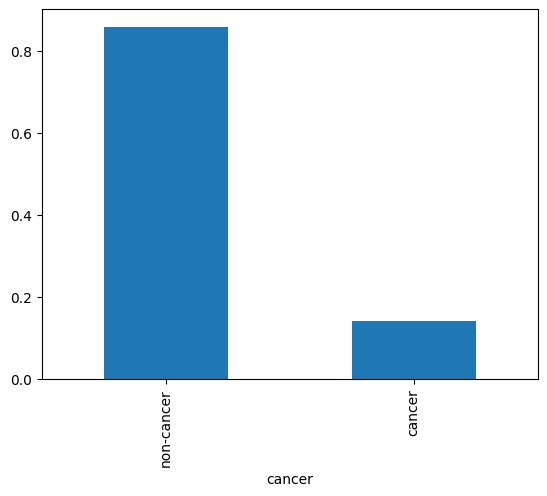

In [39]:
(df_ill.value_counts('cancer') / len(df_ill)).plot(kind='bar')

# 08-03-2024: verder met net_benefit
De prevalentie hierboven is niet een goede indruk van of het model goed is of niet, daarvoor moet je ook meenemen of het model het goede antwoord geeft of niet. Door de false positive en true positive rate te vermenigvuldigen met de prevalentie krijg je wel een betekenisvolle metric. Het schaalt de performance van het model, bv TPR het correct herkennen van kanker, naar hoe vaak de beslissing gemaakt is in de data. Hier ontwikkelen zich twee metrics:

- hoe vaak voorspellen we correct kanker, i.e. de $baten$ van het model: $TPR \times \frac{n_{cancer}}{n}$ waarbij $\frac{n_{cancer}}{n}$ de prevalentie is van kanker patienten. 
- hoe vaak voorspellen we onnodige biopsie, i.e. de $kosten$ van het model: $FPR \times \frac{n_{non-cancer}}{n}$ waarbij $\frac{n_{non-cancer}}{n}$ de prevalentie is van niet-kanker patienten

Op een aantal manieren kan deze kosten-baten analyse meer positief worden:
- Bij gelijke TPR, meer kanker patienten in de dataset (dit is een simulatie van het aantal kankerpatienten wat je door je kliniek krijgt, meer patienten is meer potentiele baten)
- Bij gelijke FPR, minder kanker patienten in de dataset
- bij gelijk aantal patienten, hogere TPR (dan wordt je model beter)
- bij gelijk aantal patienten, lagere FPR (dan wordt je model slechter)

Het voelt alsof net_benefit iets meer gevoelig voor onbalans in de data doordat de absolute aantalen patienten meespeeld in de metric. Maar het gebruikt van de rate van succes en de variabele impact door het gebruik van de odds ratio is dit bij lange na niet zo sterk als bij de accuracy. Dit maakt het anders dan de AUC, waar alleen de TPR en FPR meegenomen worden. Als je dit voor een voorbeeld TPR/FPR/threshold combinatie doorrekenend (dit is het complexe model):

0.09844559585492228 0.8125 0.23623219895568262


<Axes: >

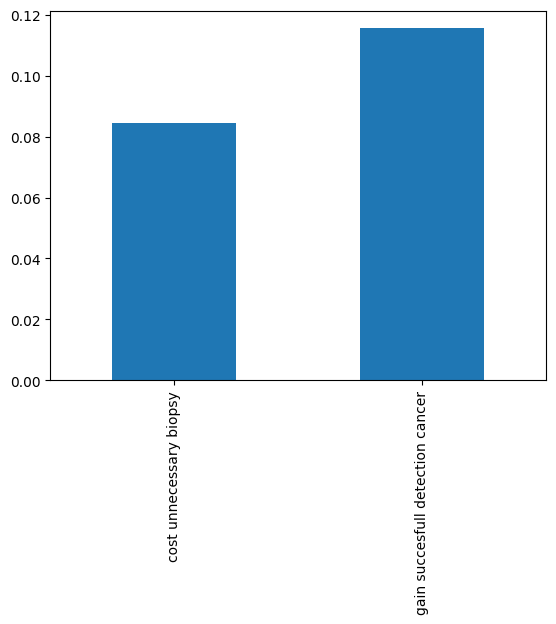

In [74]:
FPR, TPR, p = fpr_tpr.loc[12,]
prev_cancer, prev_non_cancer = (df_ill.value_counts('cancer') / len(df_ill))
pd.Series([FPR * prev_cancer, TPR * prev_non_cancer], index=['cost unnecessary biopsy', 'gain succesfull detection cancer']).plot(kind='bar')

Maar het net_benefit breidt de kosten-baten analyse nog uit doordat het expliciet maakt hoeveel nadruk je legt op de kosten van een onnodige biopsie. Dit doen we door:

$$FPR_{\theta} \times \frac{n_{non-cancer}}{n} \times \frac{\theta}{1-\theta}$$

waarbij:
- $PR_{\theta}$ de rate van onnodige biopsies als we $\theta$ als threshold voor het model kiezen. 
- $\frac{n_{non-cancer}}{n}$ de fractie niet-kanker patienten in de data, aka 1-prevalentie. 
- $\frac{\theta}{1-\theta}$ de odds ratio gebaseerd op $\theta$, als deze bijvoorbeeld 0.1 is komt deze waar uit op $\frac{1}{9}$ waardoor een onnodige biopsie negen keer minder invloed heeft op de net_benefit. Dus we zijn bereid negen onnodig biopsies te accepteren voor elke biopsie op een kanker patient. 

Hier rekenen we dit door voor ons voorbeeld uit de data:

0.09844559585492228 0.8125 0.23623219895568262


<Axes: >

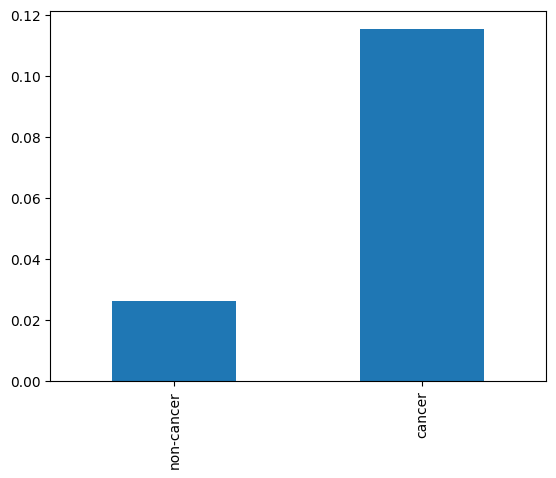

In [76]:
print(FPR, TPR, p)
(df_ill.value_counts('cancer') / len(df_ill)).multiply(fpr_tpr.loc[12,['FPR', 'TPR']])
ex_fpr_tpr = fpr_tpr.loc[12,['FPR', 'TPR']]
ex_fpr_tpr.index = ['non-cancer', 'cancer']
#(ex_fpr_tpr.multiply(df_ill.value_counts('cancer') / len(df_ill))).plot(kind='bar')
ex_fpr_tpr.multiply(df_ill.value_counts('cancer') / len(df_ill)).multiply([p/(1-p), 1]).plot(kind='bar')

Hier zie je daat de positieve impact van het correct detecteren veeel groter is dan de negatieve impact van onnodige biopsies. Dus voor deze threshold heeft het model een positieve net_benefit. 